# Forecasting - using Facebook Prophet model
#### Import necessary libraries

In [4]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px 

from prophet import Prophet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

#### NSW total energy demand data merged with temperature, price and public holiday

In [5]:
# Read the data into dataframe
df = pd.read_csv('../../../data/merged_TempDemandRRPHoliday.csv')

#df.dtypes # DATETIME is object
# convert 'DATETIME' to a datetime object
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

#### Create some functions

In [6]:
# root mean squared error (rsme)
def rmse(pred, actual): 
	return np.sqrt(((pred-actual)**2).mean())

# mean absolute percentage error (mape)
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Create time series features based on time series column 'DATETIME'
def create_features(df):
    df['YEAR'] = df['DATETIME'].dt.year
    df['MONTH'] = df['DATETIME'].dt.month
    df['DAY_OF_WEEK'] = df['DATETIME'].dt.dayofweek
    df['DAY'] = df['DATETIME'].dt.day
    df['HOUR'] = df['DATETIME'].dt.hour
    #df['HALF_HOUR'] = df['DATETIME'].dt.minute//30
    
    return df



#### Create timeseries features and add to the dataframe

In [7]:
df_extra = df.copy()
df_extra = create_features(df_extra)

Facebook prophet requires dataframe in a certain format. Column needs to be saved as '*ds*' for time series data and '*y*' for the data to be forecasted. Here, the time series is the column *DATETIME* and the data to be forecasted is the column *TOTALDEMAND*.

In [8]:
new_df = df_extra[['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'RRP','isHoliday', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'DAY', 'HOUR']].rename({'DATETIME':'ds', 
                                                                                                              'TOTALDEMAND':'y',
                                                                                                              'TEMPERATURE': 'TEMPERATURE',
                                                                                                              'RRP': 'RRP',
                                                                                                              'isHoliday': 'isHoliday',
                                                                                                              'YEAR': 'YEAR',
                                                                                                              'MONTH': 'MONTH',
                                                                                                              'DAY_OF_WEEK': 'DAY_OF_WEEK',
                                                                                                              'DAY': 'DAY',
                                                                                                              'HOUR': 'HOUR'                       
                                                                                                            }, axis='columns')
new_df.head()
new_df.shape

(219871, 10)

### Split the data into train and test data

In [9]:
train_data = new_df[new_df['ds'] < '2021-01-01']
test_data = new_df[new_df['ds'] >= '2021-01-01']

## Model-1
TOTALDEMAND is target variable. Temperature, energy price, holiday and timeseries features are used as regressiors.

In [10]:
# define the model
fbp = Prophet(interval_width=0.95)  # daily_seasonality=True)

# add regressior to the model
fbp.add_regressor('TEMPERATURE', standardize=False)
fbp.add_regressor('RRP', standardize=False)
fbp.add_regressor('isHoliday', standardize=False)
fbp.add_regressor('YEAR', standardize=False)
fbp.add_regressor('MONTH', standardize=False)
fbp.add_regressor('DAY_OF_WEEK', standardize=False)
fbp.add_regressor('DAY', standardize=False)
fbp.add_regressor('HOUR', standardize=False)

# train and fit the model
fbp.fit(train_data)

#fbp.params


15:35:08 - cmdstanpy - INFO - Chain [1] start processing
15:40:11 - cmdstanpy - INFO - Chain [1] done processing


#### Predict the future

In [11]:
# create a dataframe containing a single column of datetime. All datetime from traing data, plus the periods to be predicted 
future = fbp.make_future_dataframe(periods=27568, freq='30min') # 27568

# Add the regressors to future dataframe
future['TEMPERATURE'] = new_df['TEMPERATURE']
future['RRP'] = new_df['RRP']
future['isHoliday'] = new_df['isHoliday']
future['YEAR'] = new_df['YEAR']
future['MONTH'] = new_df['MONTH']
future['DAY_OF_WEEK'] = new_df['DAY_OF_WEEK']
future['DAY'] = new_df['DAY']
future['HOUR'] = new_df['HOUR']


# predict future
forecast = fbp.predict(future)
forecast_df = forecast[['ds','yhat','yhat_lower','yhat_upper']]

#### Visualise the prediction

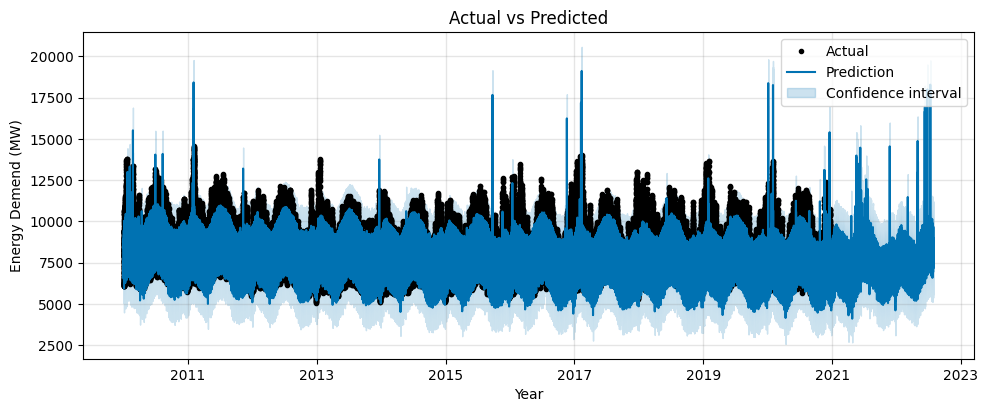

In [12]:
# visualize the prediction
#plt.figure(figsize=(6, 4))
fbp.plot(forecast, figsize=(10, 4))
plt.title("Actual vs Predicted")
plt.xlabel('Year')
plt.ylabel('Energy Demend (MW)')
plt.legend(['Actual', 'Prediction', 'Confidence interval'])
plt.show()

#### plot trend and seasonality

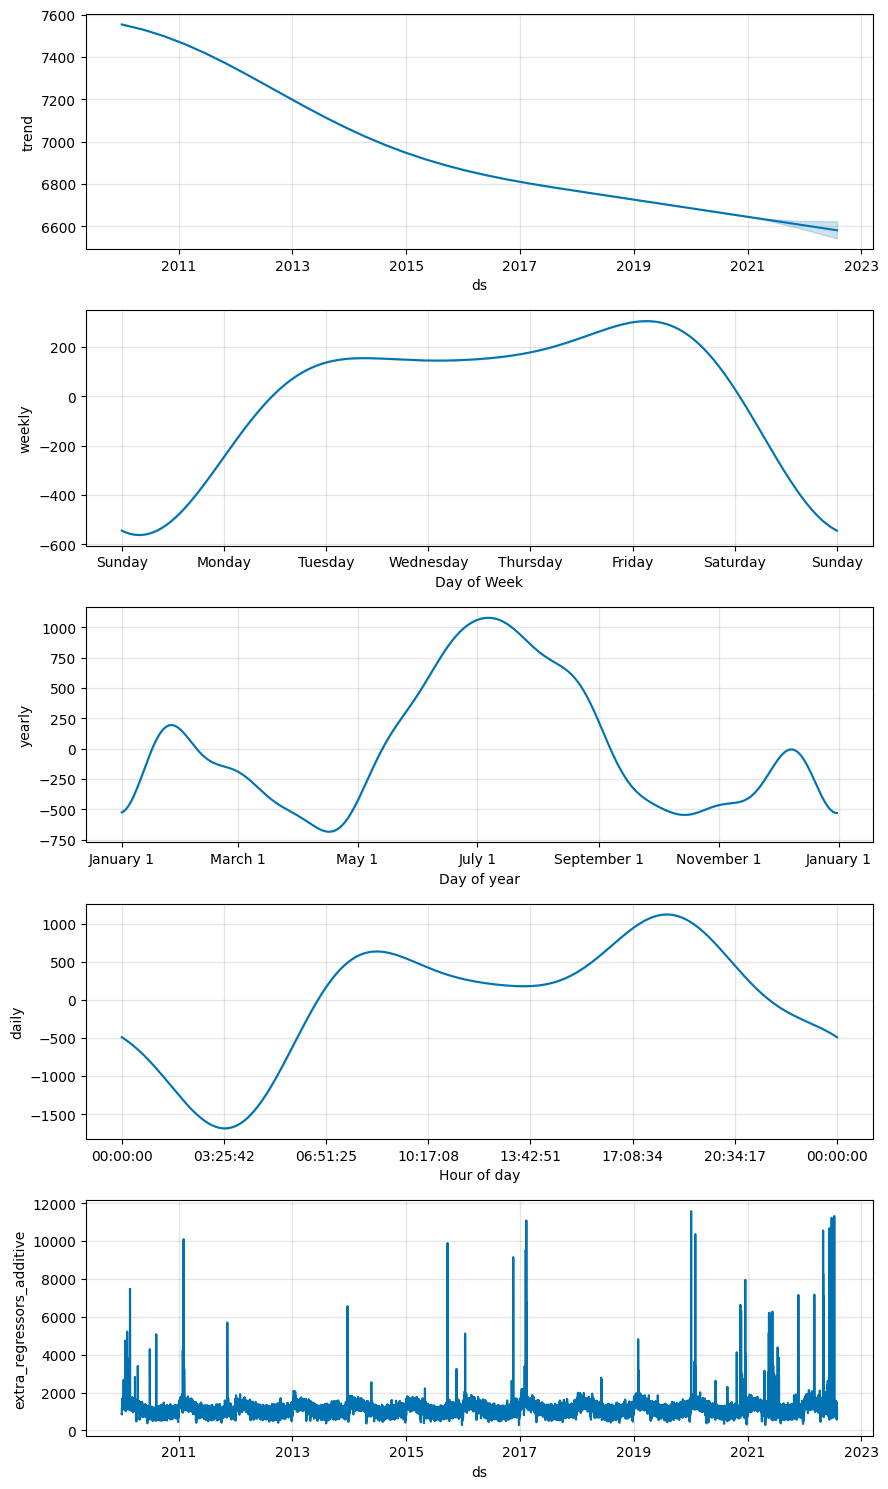

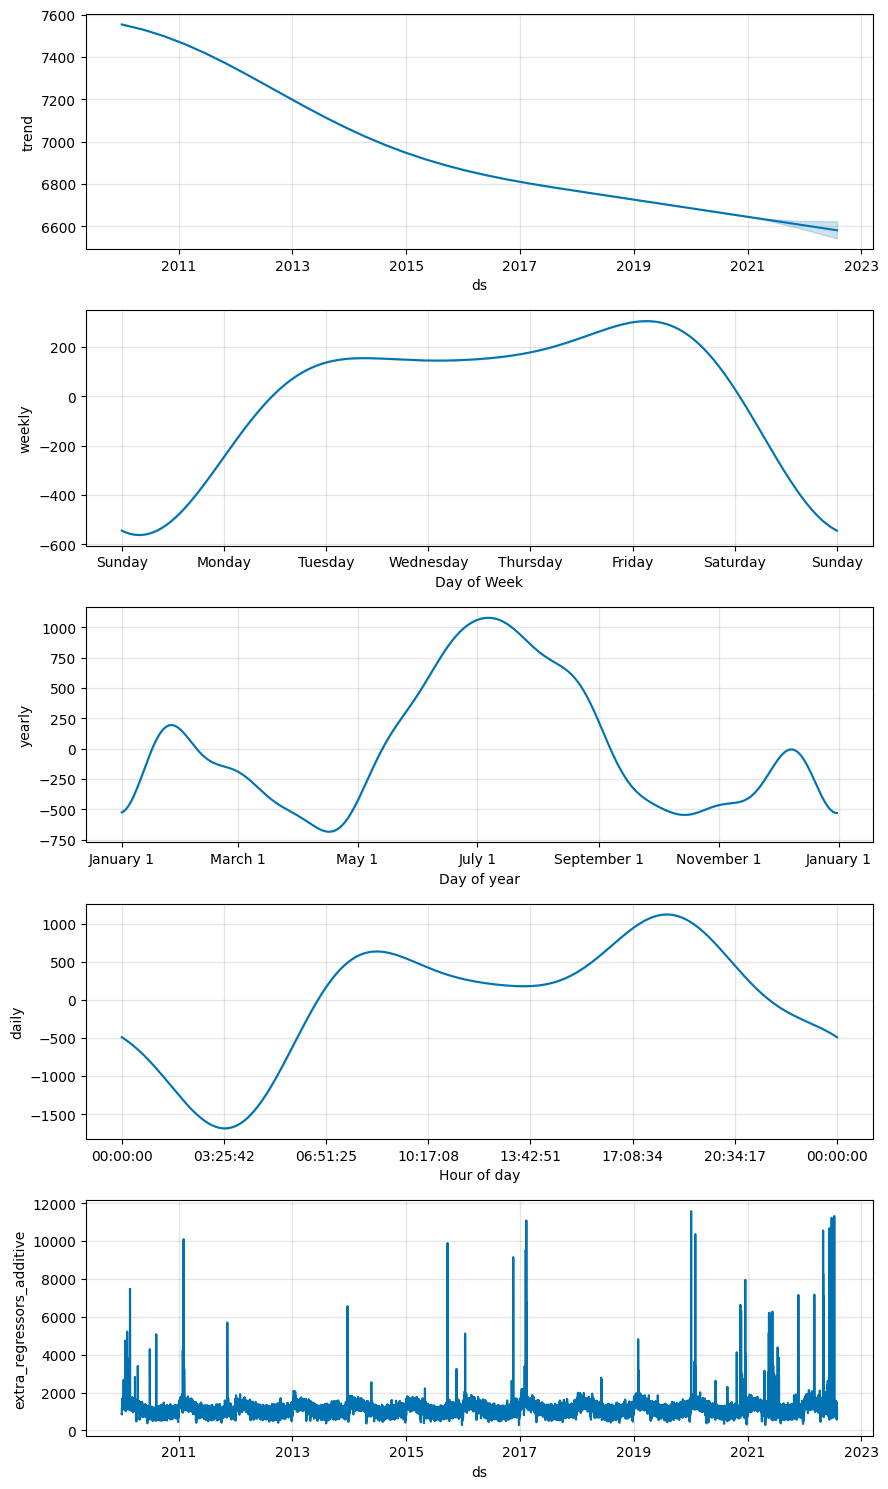

In [13]:
# plot trend and seasonality
fbp.plot_components(forecast)

### Evolution of the models

In [14]:
# evaluate the model

prediction = forecast_df.iloc[-len(test_data):]['yhat']
actual = test_data['y']

MAPE = mape(actual, prediction) # 14.720594
MAE = mean_absolute_error(actual, prediction) # 1144.885234
RMSE = rmse(actual, prediction) # 1506.504463

columns = ['Facebook Prophet', 'MAPE', 'MAE', 'RMSE']
metrics = pd.DataFrame(columns = columns)
metrics.loc[0] = ['Model-1', MAPE, MAE, RMSE]
metrics

,Facebook Prophet,MAPE,MAE,RMSE
0,Model-1,14.69612,1106.601582,1380.254022


Comment: Adding temperature as a regressor improves model performance but not significantly

## Model-2
This model used ony totaldemand data. TOTALDEMAND is target variable no other extra regressior.

In [16]:
# Read the data into dataframe
tot_demand = pd.read_csv('../../../data/totaldemand_nsw.csv')

#tot_demand.dtypes # DATETIME is object
# convert to a datetime object
tot_demand['DATETIME'] = pd.to_datetime(tot_demand['DATETIME'])

# Only keep the required feature
tot_demand = tot_demand[['DATETIME', 'TOTALDEMAND']]

# Check for duplicate DATETIME
duplicate_rows = tot_demand[tot_demand.duplicated(keep=False)] # keep=False to see all the duplicates

# drop duplicated rows
tot_demand = tot_demand.drop_duplicates()

# Check missing values
#print ("Missing values :\n", tot_demand.isnull().any())
 

#### Set the DATETIME feature as index, convert the Demand dataset into half hourly interval .

In [17]:
# Set DATETIME feature as index
tot_demand_copy = tot_demand.copy()
tot_demand_idx=tot_demand_copy.set_index('DATETIME')


# Resample the Demand data frequency into half an hour
demand_30min = tot_demand_idx['TOTALDEMAND'].resample('30min').mean() # can't be resample unless DATETIME is index
demand_30min = demand_30min.reset_index()[['DATETIME', 'TOTALDEMAND']].rename({'DATETIME':'ds', 'TOTALDEMAND':'y'}, axis='columns')

#### split the data into train and test

In [18]:
train_data3 = demand_30min[demand_30min['ds'] < '2021-01-01']
test_data3 = demand_30min[demand_30min['ds'] >= '2021-01-01']

In [19]:
# define the model
fbp3 = Prophet(interval_width=0.95)  # daily_seasonality=True)

# train and fit the model
fbp3.fit(train_data3)

16:00:49 - cmdstanpy - INFO - Chain [1] start processing
16:02:42 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# create a dataframe containing a single column of datetime. All datetime from traing data, plus the periods to be predicted 
future3 = fbp3.make_future_dataframe(periods=27697, freq='30min')

# predict future
forecast3 = fbp3.predict(future3)
forecast3_df = forecast3[['ds','yhat','yhat_lower','yhat_upper']]

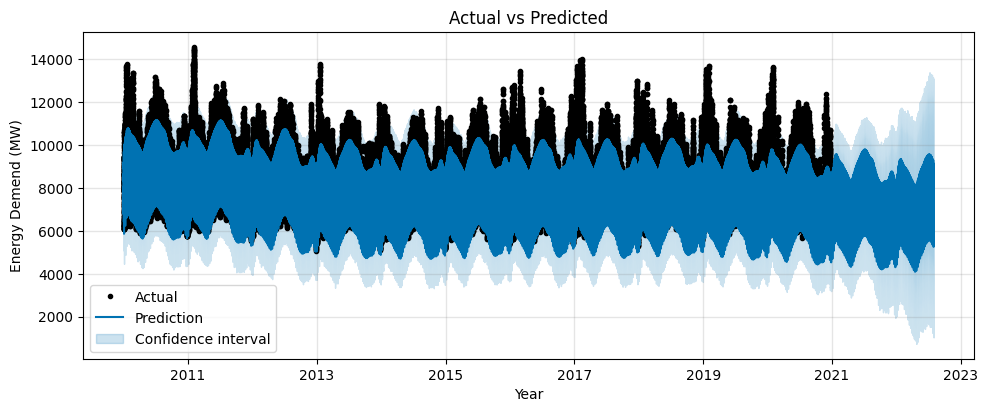

In [21]:
# visualize the prediction
fbp3.plot(forecast3, figsize=(10, 4))
plt.xlabel('Year')
plt.ylabel('Energy Demend (MW)')
plt.legend(['Actual', 'Prediction', 'Confidence interval'])
plt.title("Actual vs Predicted")
plt.show()

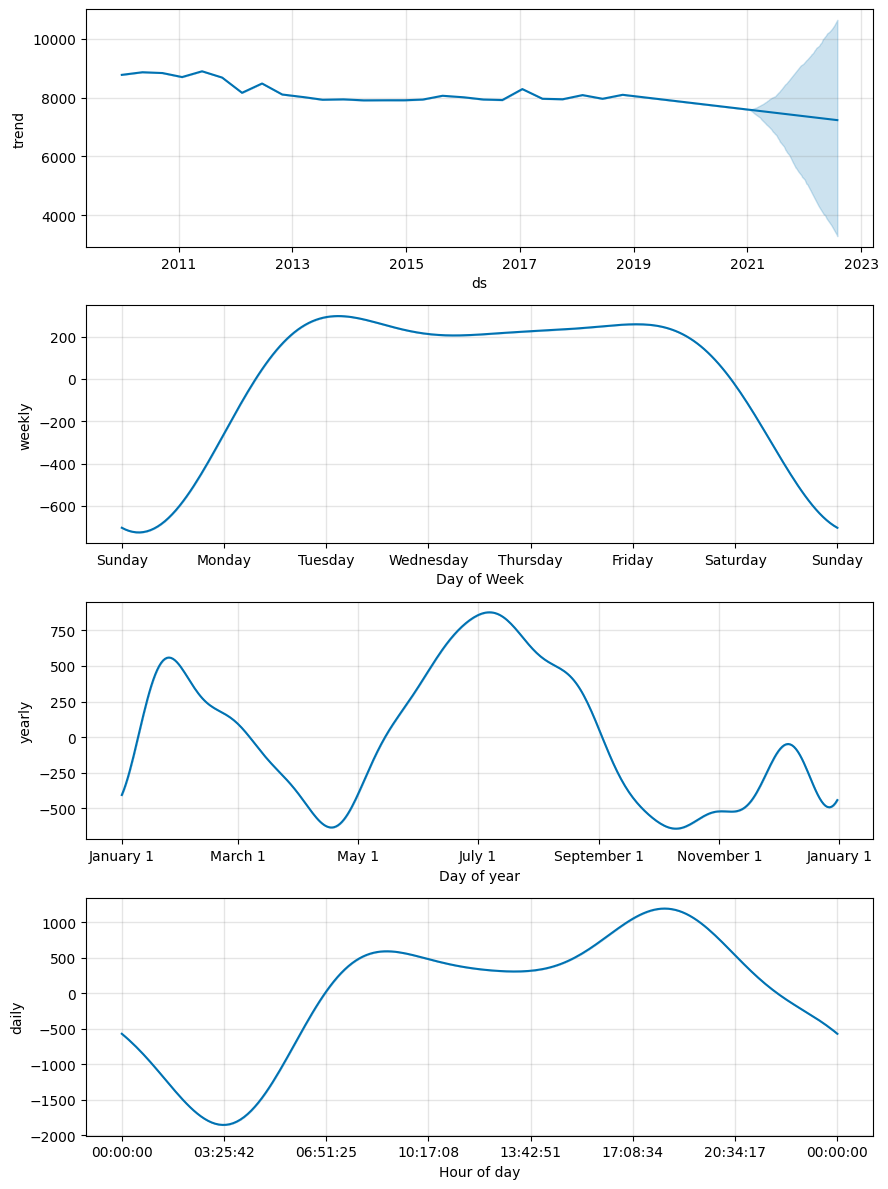

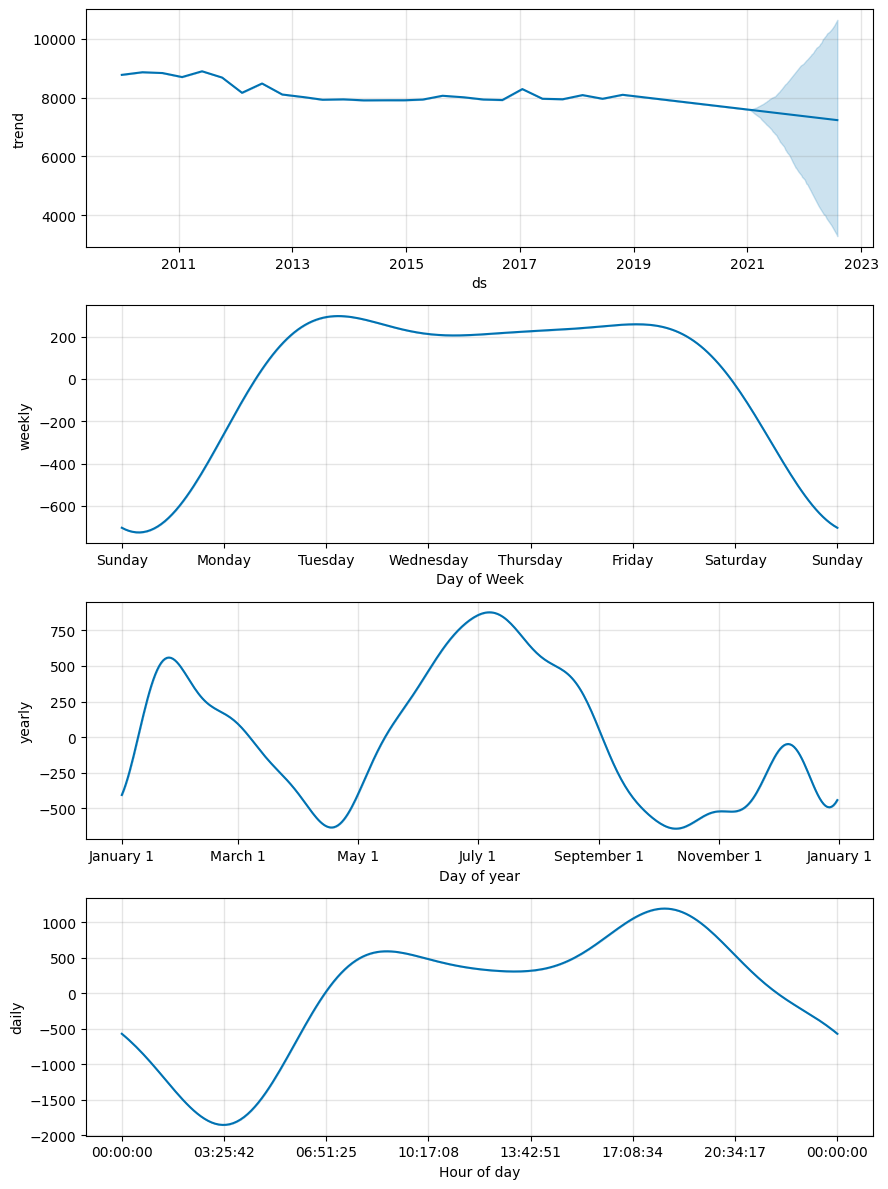

In [22]:
# plot trend and seasonality
fbp3.plot_components(forecast3)

In [23]:
# evaluate the model

prediction3 = forecast3_df.iloc[-len(test_data3):]['yhat']
actual3 = test_data3['y']

MAPE_3 = mape(actual3, prediction3) # 9.79013
MAE_3 = mean_absolute_error(actual3, prediction3) # 740.502169
RMSE_3 = rmse(actual3, prediction3) # 919.02105


#columns = ['Model', 'MAPE', 'MAE', 'RMSE']
#metrics = pd.DataFrame(columns = columns)
metrics.loc[1] = ['Model-2', MAPE_3, MAE_3, RMSE_3]
metrics

,Facebook Prophet,MAPE,MAE,RMSE
0,Model-1,14.696120,1106.601582,1380.254022
1,Model-2,9.785873,740.138680,918.605101
